### A signal on differentiation amplies noise. In this notebook we try to understand this phenomenon and remove the noise through smoothing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0, 'Time')

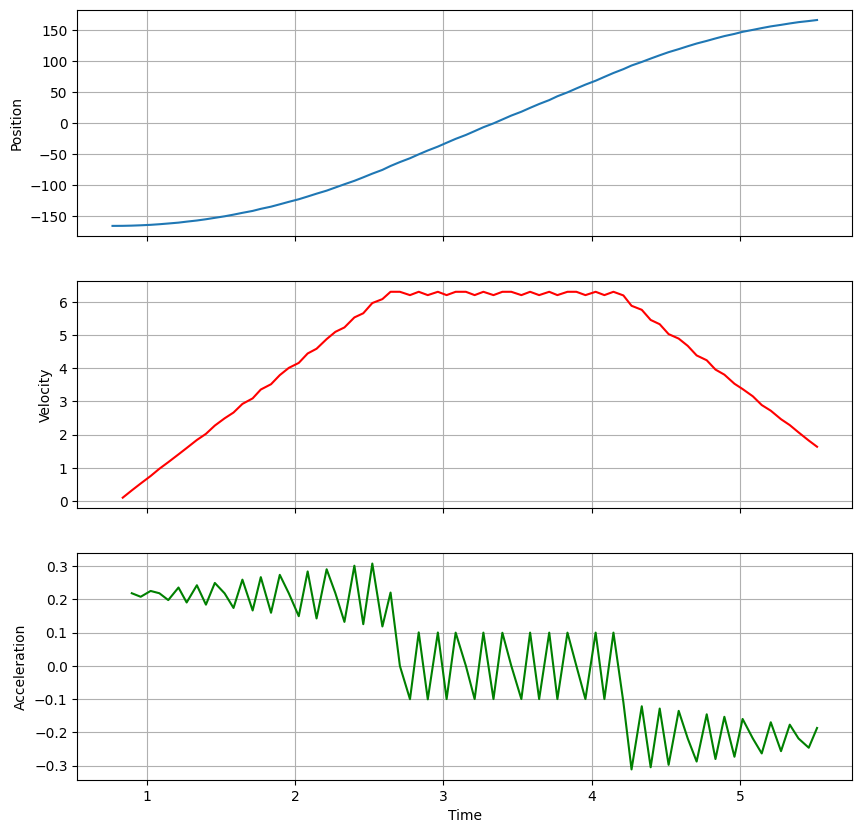

In [3]:
data = '''0.768 -166.099892
0.837 -165.994148
0.898 -165.670052
0.958 -165.138245
1.025 -164.381218
1.084 -163.405838
1.144 -162.232704
1.213 -160.824051
1.268 -159.224854
1.337 -157.383270
1.398 -155.357666
1.458 -153.082809
1.524 -150.589943
1.584 -147.923012
1.644 -144.996872
1.713 -141.904221
1.768 -138.544807
1.837 -135.025749
1.896 -131.233063
1.957 -127.222366
2.024 -123.062325
2.084 -118.618355
2.144 -114.031906
2.212 -109.155006
2.271 -104.059753
2.332 -98.832321
2.399 -93.303795
2.459 -87.649956
2.520 -81.688499
2.588 -75.608597
2.643 -69.308281
2.706 -63.008308
2.774 -56.808586
2.833 -50.508270
2.894 -44.308548
2.962 -38.008575
3.021 -31.808510
3.082 -25.508537
3.151 -19.208565
3.210 -13.008499
3.269 -6.708527
3.337 -0.508461
3.397 5.791168
3.457 12.091141
3.525 18.291206
3.584 24.591179
3.645 30.791245
3.713 37.091217
3.768 43.291283
3.836 49.591255
3.896 55.891228
3.957 62.091293
4.026 68.391266
4.085 74.591331
4.146 80.891304
4.213 87.082100
4.268 92.961502
4.337 98.719368
4.397 104.172363
4.458 109.496956
4.518 114.523888
4.586 119.415550
4.647 124.088860
4.707 128.474464
4.775 132.714500
4.834 136.674385
4.894 140.481148
4.962 144.014626
5.017 147.388458
5.086 150.543938
5.146 153.436089
5.207 156.158638
5.276 158.624725
5.335 160.914001
5.394 162.984924
5.463 164.809685
5.519 166.447678'''

data_arr = np.array([line.split() for line in data.split('\n')], dtype=float)

t, position = data_arr[:,0], data_arr[:,1]
velocity = np.diff(position)
acceleration = np.diff(velocity)

# 3 subplots for position, velocity and acceleration
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax1.plot(t, position)
ax1.set_ylabel('Position')
ax1.grid()
ax2.plot(t[1:], velocity, color='r')
ax2.set_ylabel('Velocity')
ax2.grid()
ax3.plot(t[2:], acceleration, color='g')
ax3.set_ylabel('Acceleration')
ax3.grid()
ax3.set_xlabel('Time')

### Least squares smoothing / Savitzky-Golay filters

In [9]:
# Smoothing using 5 local points
x = np.array([[-2, -1, 0, 1, 2]])
A = np.vstack([np.ones_like(x), x, x**2]).T

# Least square solution to the above matrix
# The first row is the filter coefficient for the smoothened signal
# The second row is the filter coefficients for smoothened 1st derivative of the signal
# The third row is the filter coefficients for smoothened 2nd derivative of the signal
c = np.linalg.inv(A.T @ A) @ A.T

# Multiplying 35 to convert to round numbers. This is done just to make
# the coefficients consistent with matlab/wiki.
#c = c * 35
c


array([[-0.08571429,  0.34285714,  0.48571429,  0.34285714, -0.08571429],
       [-0.2       , -0.1       ,  0.        ,  0.1       ,  0.2       ],
       [ 0.14285714, -0.07142857, -0.14285714, -0.07142857,  0.14285714]])

In [78]:
f =  c[0, :] # Filter coefficients for smoothening the signal
f1 = c[1, :] # Filter coefficients for smoothening the 1st derivative of the signal
f2 = 2 * c[2, :] # Filter coefficients for smoothening the 2nd derivative of the signal. Multiplier 2 is due to differentiating twice

# Convolution flips the coefficients. So we need to flip the coefficients before feeding it to the convolution function
f = np.flip(f)
f1 = np.flip(f1)
f2 = np.flip(f2)

In [79]:
from scipy.signal import savgol_coeffs

# The filter coefficients from scipy matches the implementation above
print(f"Filter coefficients from Scipy: {savgol_coeffs(5, 2, deriv=0)}")
print(f"Filter coefficients from this implementation: {f}")
print()

print(f"Filter coefficients for 1st deriv from Scipy: {savgol_coeffs(5, 2, deriv=1)}")
print(f"Filter coefficients for 1st deriv from this implementation: {f1}")
print()

print(f"Filter coefficients for 2nd deriv from Scipy: {savgol_coeffs(5, 2, deriv=2)}")
print(f"Filter coefficients for 2nd deriv from this implementation: {f2}")


Filter coefficients from Scipy: [-0.08571429  0.34285714  0.48571429  0.34285714 -0.08571429]
Filter coefficients from this implementation: [-0.08571429  0.34285714  0.48571429  0.34285714 -0.08571429]

Filter coefficients for 1st deriv from Scipy: [ 2.00000000e-01  1.00000000e-01  2.11210904e-16 -1.00000000e-01
 -2.00000000e-01]
Filter coefficients for 1st deriv from this implementation: [ 0.2  0.1  0.  -0.1 -0.2]

Filter coefficients for 2nd deriv from Scipy: [ 0.28571429 -0.14285714 -0.28571429 -0.14285714  0.28571429]
Filter coefficients for 2nd deriv from this implementation: [ 0.28571429 -0.14285714 -0.28571429 -0.14285714  0.28571429]


### Computing smoothened signal estimates manually first and then convolution APIs to compare the results

Scipy 1d convolution example

E.g
x = 1 2 3

1)
2, 1, 1, 2, 3, 3, 2
0, 3, 2, 1

3 + 2 + 2 = 7

2)
2, 1, 1, 2, 3, 3, 2
0, 0, 3, 2, 1

3 + 4 + 3 = 10

3)
2, 1, 1, 2, 3, 3, 2
0, 0, 0, 3, 2, 1

6 + 6 + 3 = 15

Text(0.5, 0, 'Time')

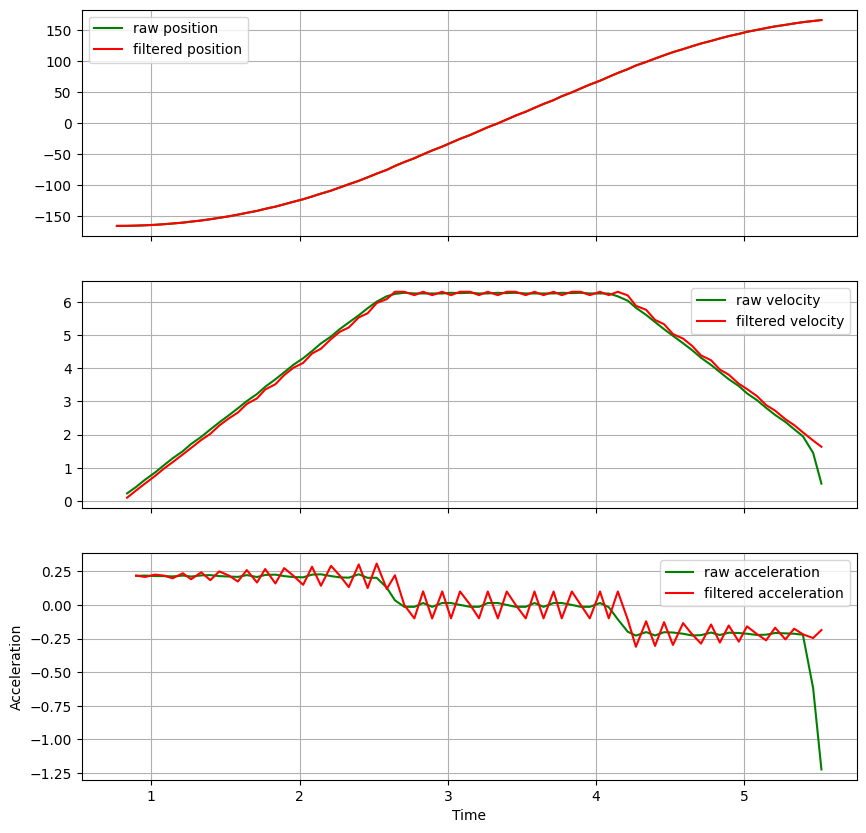

In [80]:
from scipy.ndimage import convolve1d

position_filtered = convolve1d(position, f)
velocity_filtered =  convolve1d(position, f1)[1:]
acceleration_filtered = convolve1d(position, f2)[2:]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax1.plot(t, position_filtered, color='g', label='raw position')
ax1.plot(t, position, color='r', label='filtered position')
ax1.legend()
ax1.grid()
ax2.plot(t[1:], velocity_filtered, color='g', label='raw velocity')
ax2.plot(t[1:], velocity, color='r', label='filtered velocity')
ax2.legend()
ax2.grid()
ax3.plot(t[2:], acceleration_filtered, color='g', label='raw acceleration')
ax3.plot(t[2:], acceleration, color='r', label='filtered acceleration')
ax3.set_ylabel('Acceleration')
ax3.grid()
ax3.legend()
ax3.set_xlabel('Time')

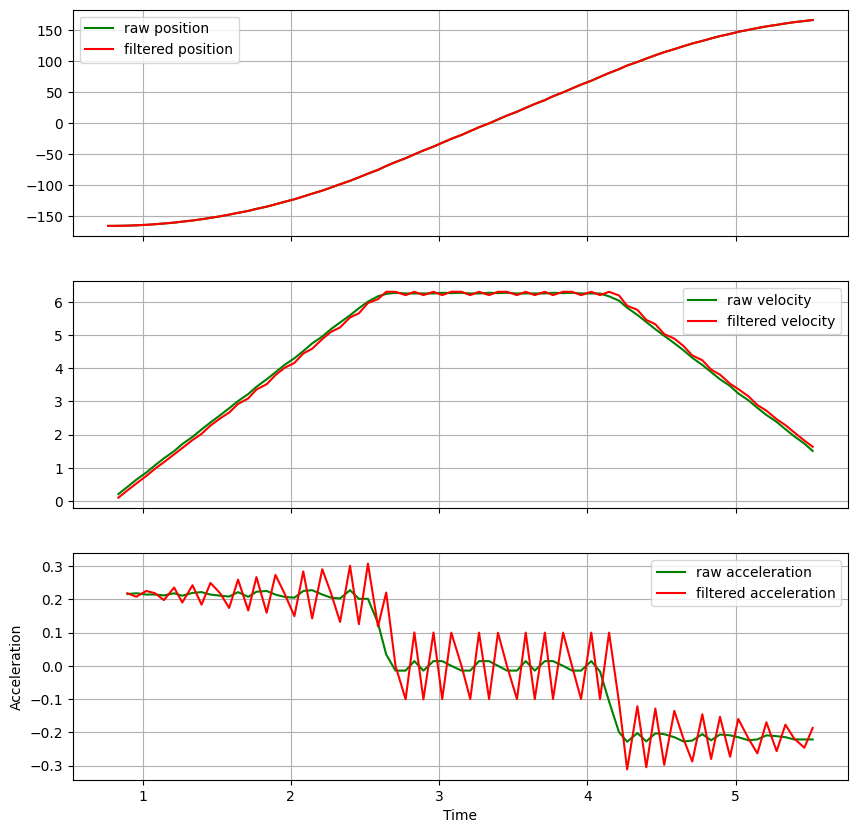

In [76]:
from scipy.signal import savgol_filter

def plot_smoothened_estimates(position, window_length, poly_order):
    position_filtered = savgol_filter(position, window_length=window_length, polyorder=poly_order)
    velocity_filtered = savgol_filter(position, window_length=window_length, polyorder=poly_order, deriv=1)[1:]
    acceleration_filtered = savgol_filter(position, window_length=window_length, polyorder=poly_order, deriv=2)[2:]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    ax1.plot(t, position_filtered, color='g', label='raw position')
    ax1.plot(t, position, color='r', label='filtered position')
    ax1.legend()
    ax1.grid()
    ax2.plot(t[1:], velocity_filtered, color='g', label='raw velocity')
    ax2.plot(t[1:], velocity, color='r', label='filtered velocity')
    ax2.legend()
    ax2.grid()
    ax3.plot(t[2:], acceleration_filtered, color='g', label='raw acceleration')
    ax3.plot(t[2:], acceleration, color='r', label='filtered acceleration')
    ax3.set_ylabel('Acceleration')
    ax3.grid()
    ax3.legend()
    ax3.set_xlabel('Time')

plot_smoothened_estimates(position, 5, 2)

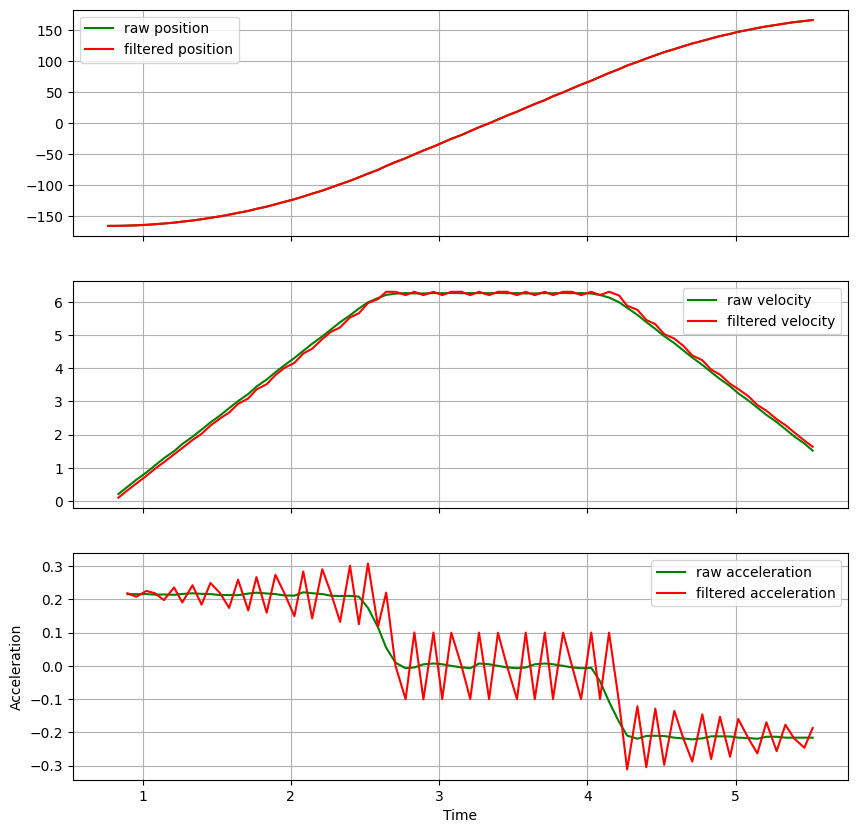

In [77]:
plot_smoothened_estimates(position, 7, 2)